<a href="https://colab.research.google.com/github/a123700/Leo/blob/master/Pricing_derivatives_with_risk_neutral_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q yfinance

     |████████████████████████████████| 62 kB 1.3 MB/s 


In [ ]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf
# from pandas_datareader import data as pdr

# Compute VaR and CVaR with historical data

In [ ]:
oex = ['0050.TW', '2454.TW']

num_stocks = len(oex)

data = yf.download(oex, start='1990-01-01', end='2016-04-04')

returns = data['Adj Close'].pct_change()
returns = returns - returns.mean(skipna=True) # de-mean the returns

[*********************100%***********************]  2 of 2 completed


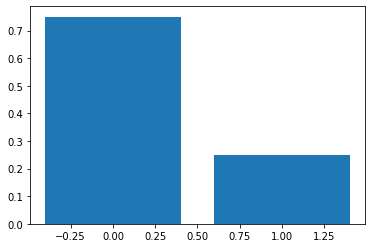

In [ ]:
def scale(x):
    return x / np.sum(np.abs(x))

weights = [0.75, 0.25]
plt.bar(np.arange(num_stocks),weights)
plt.show()

In [ ]:
def value_at_risk(
    value_invested, 
    returns, weights, 
    alpha=0.95, 
    lookback_days=500
):
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

In [ ]:
def cvar(
    value_invested, 
    returns, 
    weights, 
    alpha=0.95, 
    lookback_days=500
):
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    var_pct_loss = var / value_invested
    
    return np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss]) * value_invested

In [ ]:
value_invested = 100000
lookback_days = 2000

print(cvar(value_invested, returns, weights, lookback_days=lookback_days))
print(value_at_risk(value_invested, returns, weights, lookback_days=lookback_days))

-3608.1254324397983
-2313.137898764439


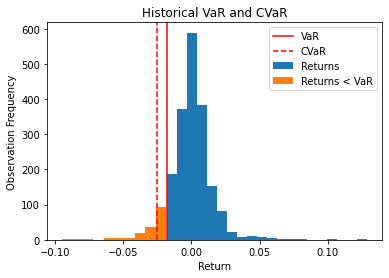

In [ ]:
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights)
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights)
portfolio_CVaR_return = portfolio_CVaR / value_invested

plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=10)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid')
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed')
plt.legend(['VaR', 'CVaR', 'Returns', 'Returns < VaR'])
plt.title('Historical VaR and CVaR')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')
plt.show()

# Compute VaR and CVaR with MC simulation

In [ ]:
# import data
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

In [ ]:
stockList = ['2454', '0050']
stocks = [stock + '.TW' for stock in stockList]
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=lookback_days)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%***********************]  2 of 2 completed


In [ ]:
# Monte Carlo Method
mc_sims = 10000 # number of simulations
T = lookback_days #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = value_invested

for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

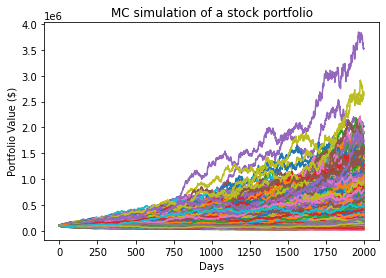

In [ ]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [ ]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [ ]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))

VaR_5 $17381.07
CVaR_5 $34754.25


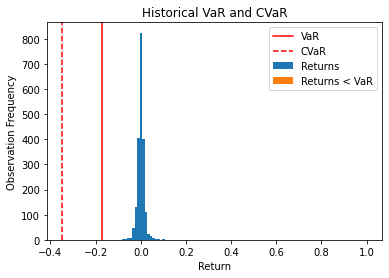

In [ ]:
profolio_returns = portfolio_sims[0]/initialPortfolio -1
VaR_returns = -VaR/initialPortfolio
CVaR_returns = -CVaR/initialPortfolio

plt.hist(portfolio_returns[portfolio_returns > VaR_returns], bins=20)
plt.hist(portfolio_returns[portfolio_returns < VaR_returns], bins=10)
plt.axvline(VaR_returns, color='red', linestyle='solid')
plt.axvline(CVaR_returns, color='red', linestyle='dashed')
plt.legend(['VaR', 'CVaR', 'Returns', 'Returns < VaR'])
plt.title('Historical VaR and CVaR')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')
plt.show()

# Pricing derivatives with risk-neutral pricing 
## (Brownian Motion is representative of risk-neutral probabilities under ℚ-measure)

Valuation of Financial Derivatives through Monte Carlo Simulations is only possible by using the Financial Mathematics of Risk-Neutral Pricing and simulating risk-neutral asset paths.

CtBt=𝔼ℚ[CTBT∣Ft]

Note: This is the Risk-neutral Expectation Pricing Formula in Continuous Time

In [ ]:
def vol_cal(stock_name):
  stock = yf.download(stock_name, '2010-01-01')['Close']
  change = stock.pct_change().dropna()
  return stock[-1]*5, np.std(change, ddof=1)

In [ ]:
# initial derivative parameters 
S, vol = vol_cal('^TWII')         #stock price and volatility (%)
K = 14500*5          #strike price
r = 0.02            #risk-free rate (%)
N = 100              #number of time steps
M = 1000            #number of simulations

market_value = 305 #market price of option
T = ((datetime.date(2023, 1, 18)-datetime.date(2022, 12, 18)).days+1)/365    #time in years
assert T > 0, 'Wrong Timeframe'

[*********************100%***********************]  1 of 1 completed


# Iteration Solution


In [ ]:
# # Precompute constants
# dt = T/N
# nudt = (r - 0.5*vol**2)*dt
# volsdt = vol*np.sqrt(dt)
# lnS = np.log(S)

# # Standard Error Placeholders
# sum_CT = 0
# sum_CT2 = 0

# # Monte Carlo Method
# for i in range(M):
#     lnSt = lnS
#     for j in range(N):
#         lnSt = lnSt + nudt + volsdt*np.random.normal()
    
#     ST = np.exp(lnSt)
#     CT = max(0, ST - K)
#     sum_CT = sum_CT + CT
#     sum_CT2 = sum_CT2 + CT*CT

# # Compute Expectation and SE
# C0 = np.exp(-r*T)*sum_CT/M
# sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
# SE = sigma/np.sqrt(M)

# print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

# Vectorized Solution


In [ ]:
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $278.62 with SE +/- 6.02


For simple processes where the SDE does not need to be approximated like in the case of Geometric Brownian Motion used for calculating a European Option Price, we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.

In [ ]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $278.77 with SE +/- 6.24


# Visualisation of Convergence


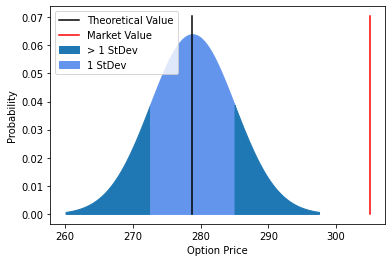

In [ ]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

plt.fill_between(x1, s1, color='tab:blue',label='> 1 StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()

# Monte Carlo Variance Reduction Methods – Antithetic


## Implementation of Antithetic Variate


In [ ]:
#precompute constants
N = 1000
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt1 = nudt + volsdt*Z 
delta_lnSt2 = nudt - volsdt*Z 
lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0)
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)
# Compute Expectation and SE
ST1 = np.exp(lnSt1)
ST2 = np.exp(lnSt2)
CT = 0.5 * ( np.maximum(0, ST1[-1] - K) + np.maximum(0, ST2[-1] - K) )
C0 = np.exp(-r*T)*np.sum(CT)/M
sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $280.28 with SE +/- 0.91


## Compare without Antithetic Variate


In [ ]:
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )
# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0w = np.exp(-r*T)*np.sum(CT[-1])/M
sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SEw = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $280.28 with SE +/- 0.91


# Visualisation of Convergence


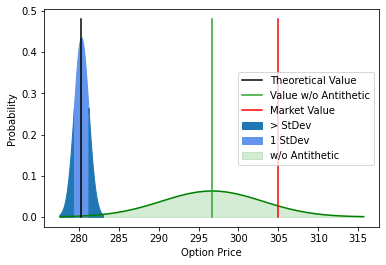

In [ ]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)
s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)
plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Antithetic')
plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='tab:green',
        label='Value w/o Antithetic')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')
plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()